# `snell_example.ipynb`

In [2]:
from snell import snell
import matplotlib.pyplot as plt
import numpy as np
import imageio

%matplotlib notebook
%load_ext autoreload
%autoreload

### Initialize display variables using class constructor
Below, we initialize the "virtual display," which maps absolute pixel coordinates to warped, Snell-transformed coordinates. Input image dimensions must match the virtual display dimensions. The virtual display is square, and its properties are set with the following parameters:

**Relevant methods:**

**snell.make_display** *(dispres, dispcm, da, dw, config = *`flat_stochastic`*, stoch_range = 2.0, num_stochastic = 5, supersample_deg = 4, nw = 4/3, na = 1)*. Initializes the virtual display.
- **dispres**. *integer*. The virtual display resolution, **in pixels**. The virtual display will be set to be shape (dispres, dispres). All subsequent images must match these display dimensions. 
- **dispcm**. *float64*. The width of the virtual display, **in cm**.
- **da**. *float64*. The distance between the bottom of the dish and the screen, **in cm**. 
- **dw**. *float64*. The distance between the fish and the bottom of the dish, **in cm**.

#### Optional parameters
- **config**. {`flat_stochastic`, `flat`}. Default `flat_stochastic`. This sets the virtual display 'mode'. Both `flat_stochastic` and `flat` assume the screen is flat. `flat_stochastic` will utilize stochastic supersampling to reduce aliasing artifacts when transforming images.
- **stoch_range**. *float64*. Default 2.0. The range of random offsets applied to each pixel in units of pixels, used in `flat_stochastic` mode
- **num_stochastic**. *integer*. Default 5. The number of stochastic samples for each pixel, used in `flat_stochastic` mode.
- **supersample_deg**. *integer*. Default 4. The degree of supersampling, used in `flat_stochastic` mode. Each transformed pixel position is the average of `supersample_deg` tranformed subpixel positions. 
- **nw**. *float64*. Default 4/3. Refractive index of fish medium (e.g. water). 
- **na**. *float64*. Default 1. Refractive index of the medium separating the dish from the screen (e.g. air).

In [9]:
np.arcsin(1/1.59)*180/np.pi

38.97128417649458

In [23]:
%matplotlib notebook

In [24]:
nop = snell.snell(dispres = 1000, dispcm = 4, da = 1/11, dw = 10/11)
nop.make_display()

In [32]:
display_stochastic = snell.snell(dispres = 1000, dispcm = 4, da = 1/12, dw = 10/12,dp=1/12,np_=1.59)
display_stochastic.make_display()

Adding plastic interface...
Adding plastic interface...
Adding plastic interface...
Adding plastic interface...
Adding plastic interface...


## Load and transform an example image

The input should be an image of any standard format that matches the dimensions of the virtual display. Thus, images can be created with the tool of your choice and then loaded in here. 

The raw pixel intensities should be in linear perceptual units in the range [0, 255], as the tool will transform these perceptual units into physical light levels to mimic standard nonlinearities of the projection system ($\gamma$ = 2.2) and match the desired contrast range of the projector. The physical illuminance levels, in lux, of black pixels (value "0") and white pixels (value "255") are passed to `transform_images_loop` as, for example, `min_lux = 1` and `max_lux = 500`.

Our model treats the fish eye as a pinhole detector, whereas real photoreceptors blur visual signals on a spatial scale determined by their receptive field. Consequently, our simulation compresses a large amount of light onto the overly thin border of the Snell window, and the tool saturates grayscale color axes in order to avoid visually distracting artifacts.

**Relevant methods:**

**snell.transform_images_loop** *(im, min_lux, max_lux, smooth = False, downsample = False, lux = False)*. Returns transformed image.
- **im**. *2-D numpy array*. Input image to be transformed.
- **min_lux**. *float64*. Lowest projector output level (in lux).
- **max_lux**. *float64*. Highest projector output level (in lux).

#### Optional parameters
- **smooth**. *boolean*. Default *False*. If *True*, smooths output with a Gaussian kernel (standard deviation = 5 pixels).
- **downsample**. *boolean* or *integer*. Default *False*. If integer, downsamples the output by the specified integer factor.
- **lux**. *boolean*. Default *False*. If *True*, does not gamma-encode the image to produce physical light levels. Rather, it expects that the input image already be in physical light units.
- **gma**. *float64*. Default 2.2. The gamma value used to convert between physical and perceptual units.

### Sine Grating

In [26]:
OMR_air = imageio.imread('examples/example_grating_dsm.tif')
OMR_air=255*(OMR_air-np.min(OMR_air))/(np.max(OMR_air)-np.min(OMR_air))

In [27]:
o_nop = nop.transform_images_loop(OMR_air, min_lux = 1, max_lux = 500)

In [33]:
OMR_snell_stochastic = display_stochastic.transform_images_loop(OMR_air, 
                                                                 min_lux = 1, 
                                                                 max_lux = 500)

Snell window (yellow) for scale. **97.2 degrees**

<IPython.core.display.Javascript object>


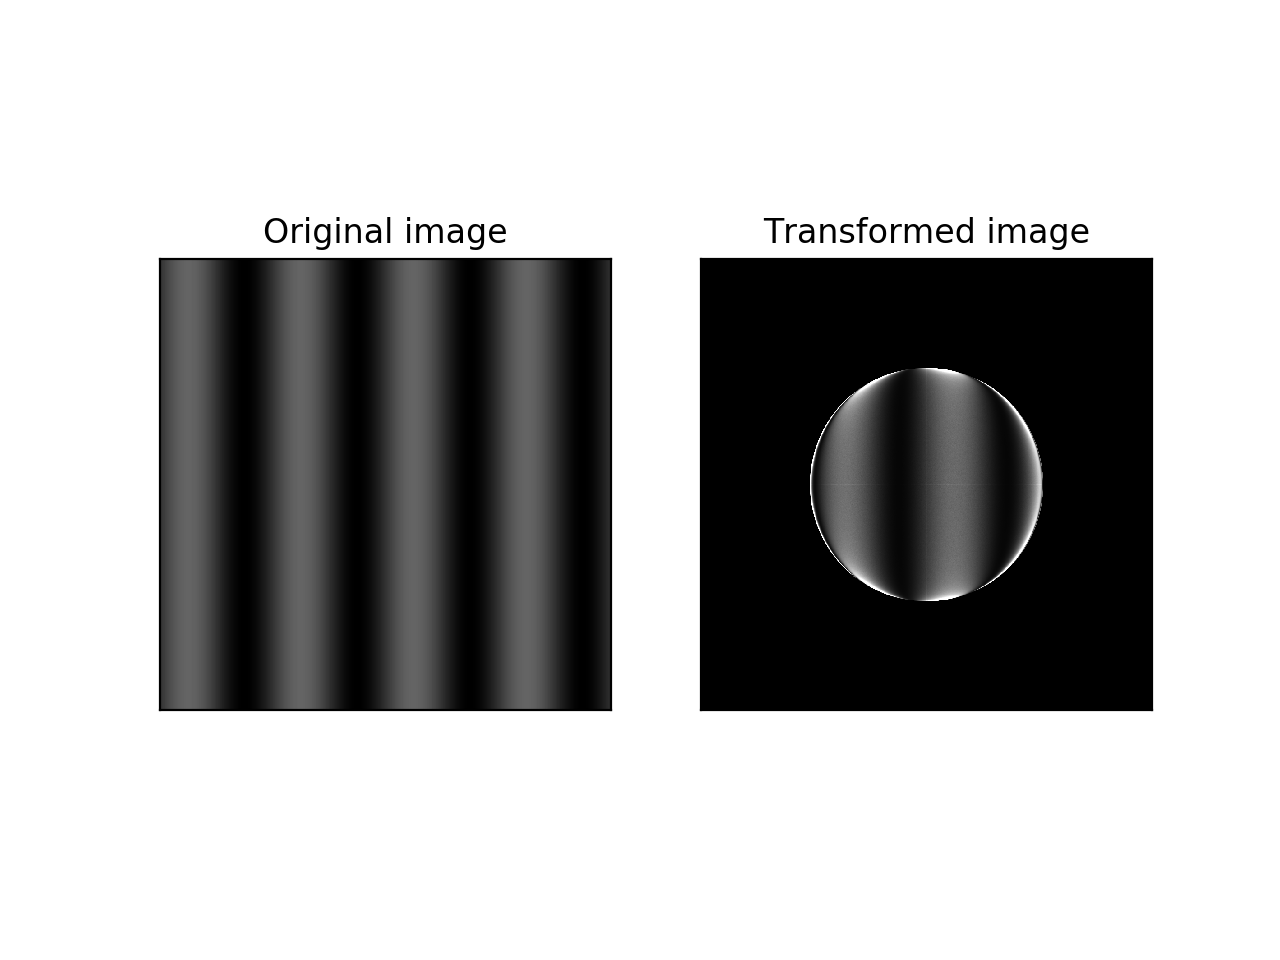

Text(0.5, 1.0, 'Transformed image')

In [35]:
# Set image saturation
VMAX = 650

plt.figure()
plt.subplot(121)
plt.imshow(OMR_air,vmax=VMAX,cmap='gray')
plt.xticks([])
plt.yticks([])
# Plot scale bar
plt.title("Original image")
plt.subplot(122)
plt.imshow(OMR_snell_stochastic,vmax=VMAX,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Transformed image")
# Plot scale bar
#display_stochastic.add_scale()

<IPython.core.display.Javascript object>


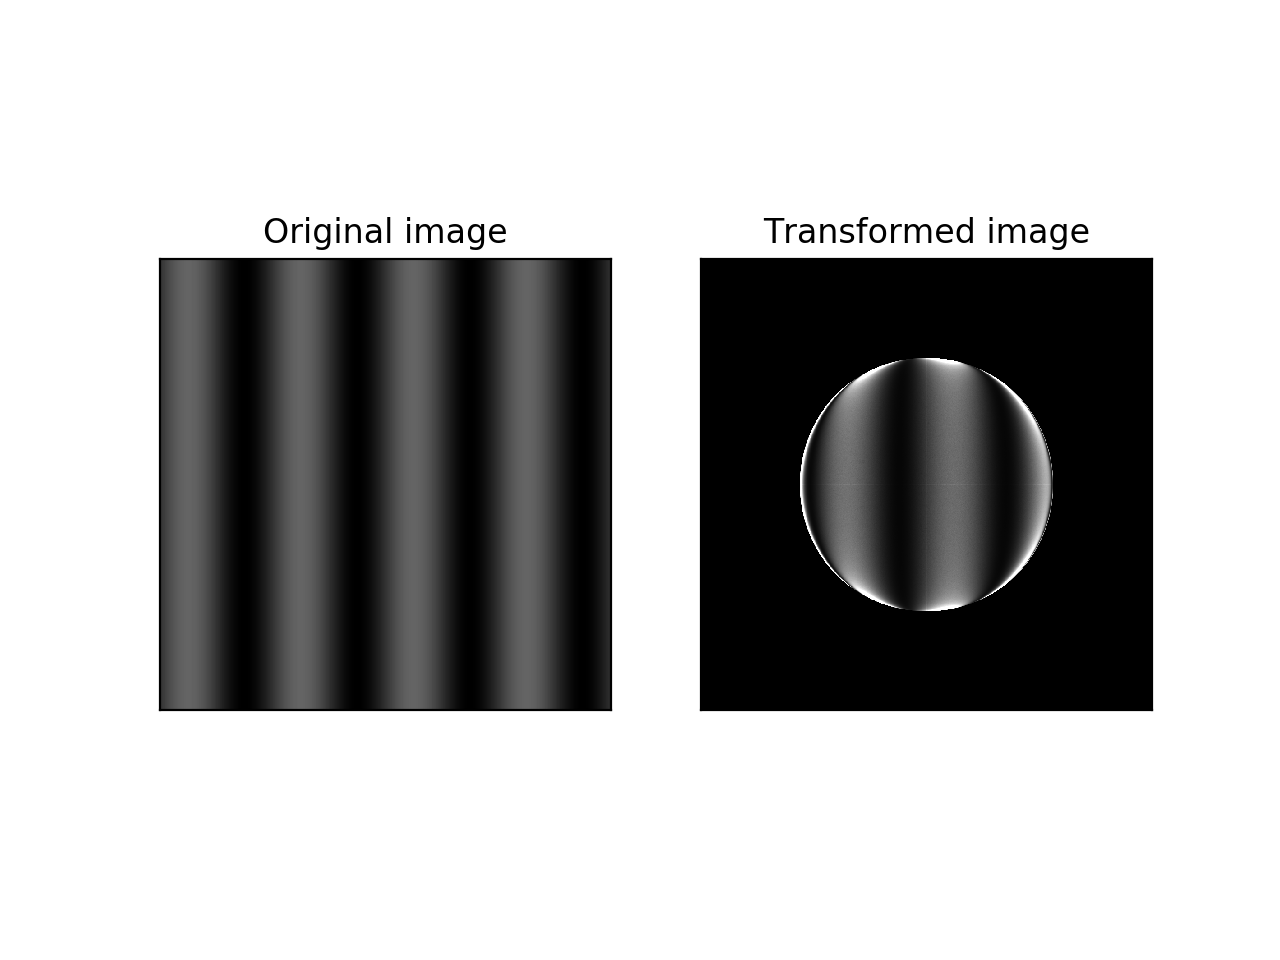

Text(0.5, 1.0, 'Transformed image')

In [36]:
# Set image saturation
VMAX = 650

plt.figure()
plt.subplot(121)
plt.imshow(OMR_air,vmax=VMAX,cmap='gray')
plt.xticks([])
plt.yticks([])
# Plot scale bar
plt.title("Original image")
plt.subplot(122)
plt.imshow(o_nop,vmax=VMAX,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Transformed image")
# Plot scale bar
#nop.add_scale()

# Design an input to produce the desired stimulus

Here we present example code for reading a target image and deriving its inverse transformation. In particular, the tool will return the image that should be presented in order for the Snell distortion to result in the desired visual stimulus for the fish.

As before, the raw pixel intensities should be in linear perceptual units in the range [0, 255], as the tool will transform perceptual units into physical light levels to mimic standard nonlinearities of the projection system ($\gamma$ = 2.2) and match the desired contrast range of the projector. The physical illuminance levels, in lux, of black pixels (value "0") and white pixels (value "255") are passed to `inverse_transform_images_loop` as, for example, `min_lux = 1` and `max_lux = 500`.

**Relevant methods:**

**snell.inverse_transform_images_loop** *(im, min_lux, max_lux, idealized = False)*. Returns untransformed image.
- **im**. *2-D numpy array*. Image of desired stimulus.
- **min_lux**. *float64*. Lowest projector output level (in lux).
- **max_lux**. *float64*. Highest projector output level (in lux).

#### Optional parameters
- **idealized**. *boolean*. Default *False*. If *True*, allows for outputs that cannot be generated by projector. When **idealized** is *False* and **min_lux** is positive, artifacts of the projector's background light level can be visible inside the Snell window.

In [37]:
check_air = imageio.imread('examples/example_check.tif')
check_air = 100*(check_air-np.min(check_air))/(np.max(check_air)-np.min(check_air))

In [38]:
inverse, forward= display_stochastic.inverse_transform_image_loop(check_air,
                                                                   min_lux=1,
                                                                   max_lux=500,
                                                                   idealized=True)

inverting image...
1/5 ...
2/5 ...
3/5 ...
4/5 ...
5/5 ...
Done.
Performing forward transformation...


Snell window (yellow) for scale. **97.2 degrees**

<IPython.core.display.Javascript object>


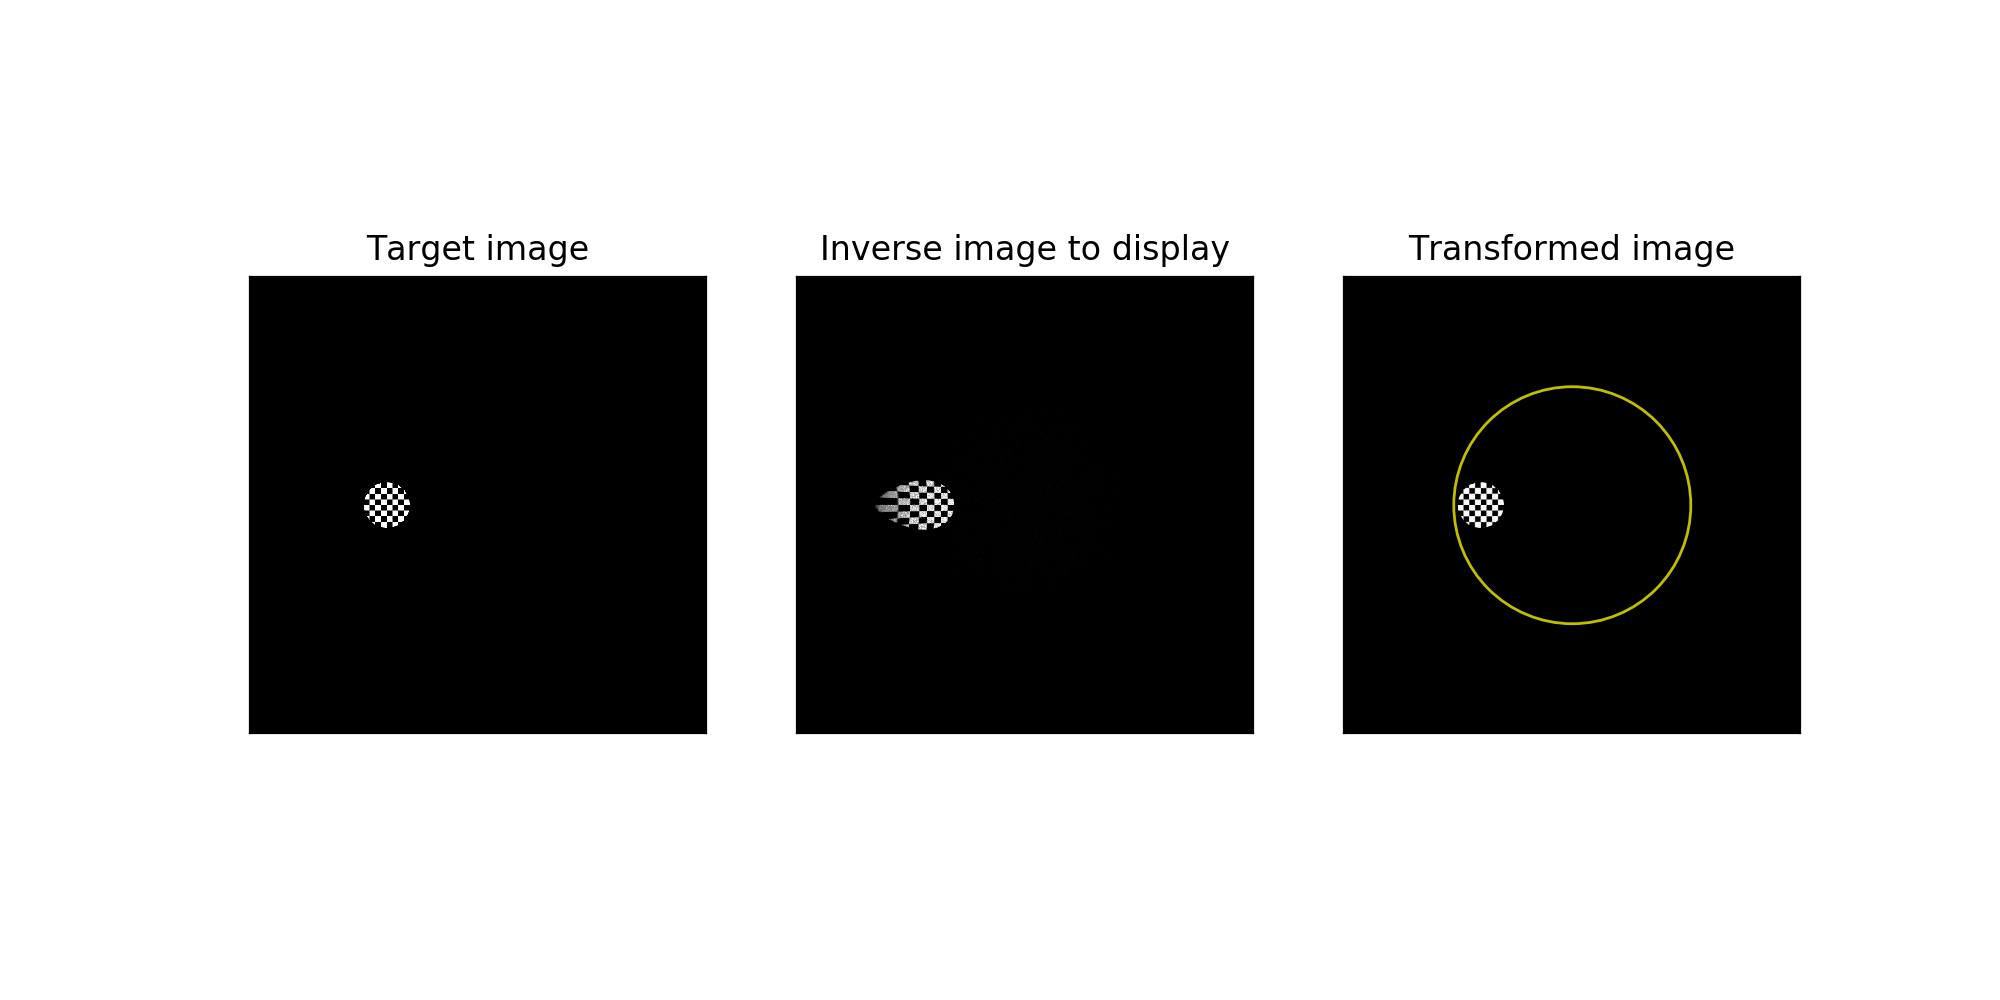

In [39]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(check_air,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Target image')
plt.subplot(132)
plt.imshow(inverse,vmin=np.min(check_air),vmax=np.max(check_air),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Inverse image to display')
plt.subplot(133)
plt.imshow(forward,vmin=np.min(check_air),vmax=np.max(check_air),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Transformed image")
# Plot scale bar
display_stochastic.add_scale()

# Physically impossible stimuli

Optical refraction compresses the entire visual field into the Snell window. Consequently, it is possible to specify target images that cannot be realized by any inverse image. Here we demostrate what happens when the user requests the tool to solve an impossible task by considering whole-field OMR grating.

In [40]:
inverse, forward = display_stochastic.inverse_transform_image_loop(OMR_air,min_lux=1,max_lux=500,idealized=True)

inverting image...
1/5 ...
2/5 ...
3/5 ...
4/5 ...
5/5 ...
Done.
Performing forward transformation...


<IPython.core.display.Javascript object>


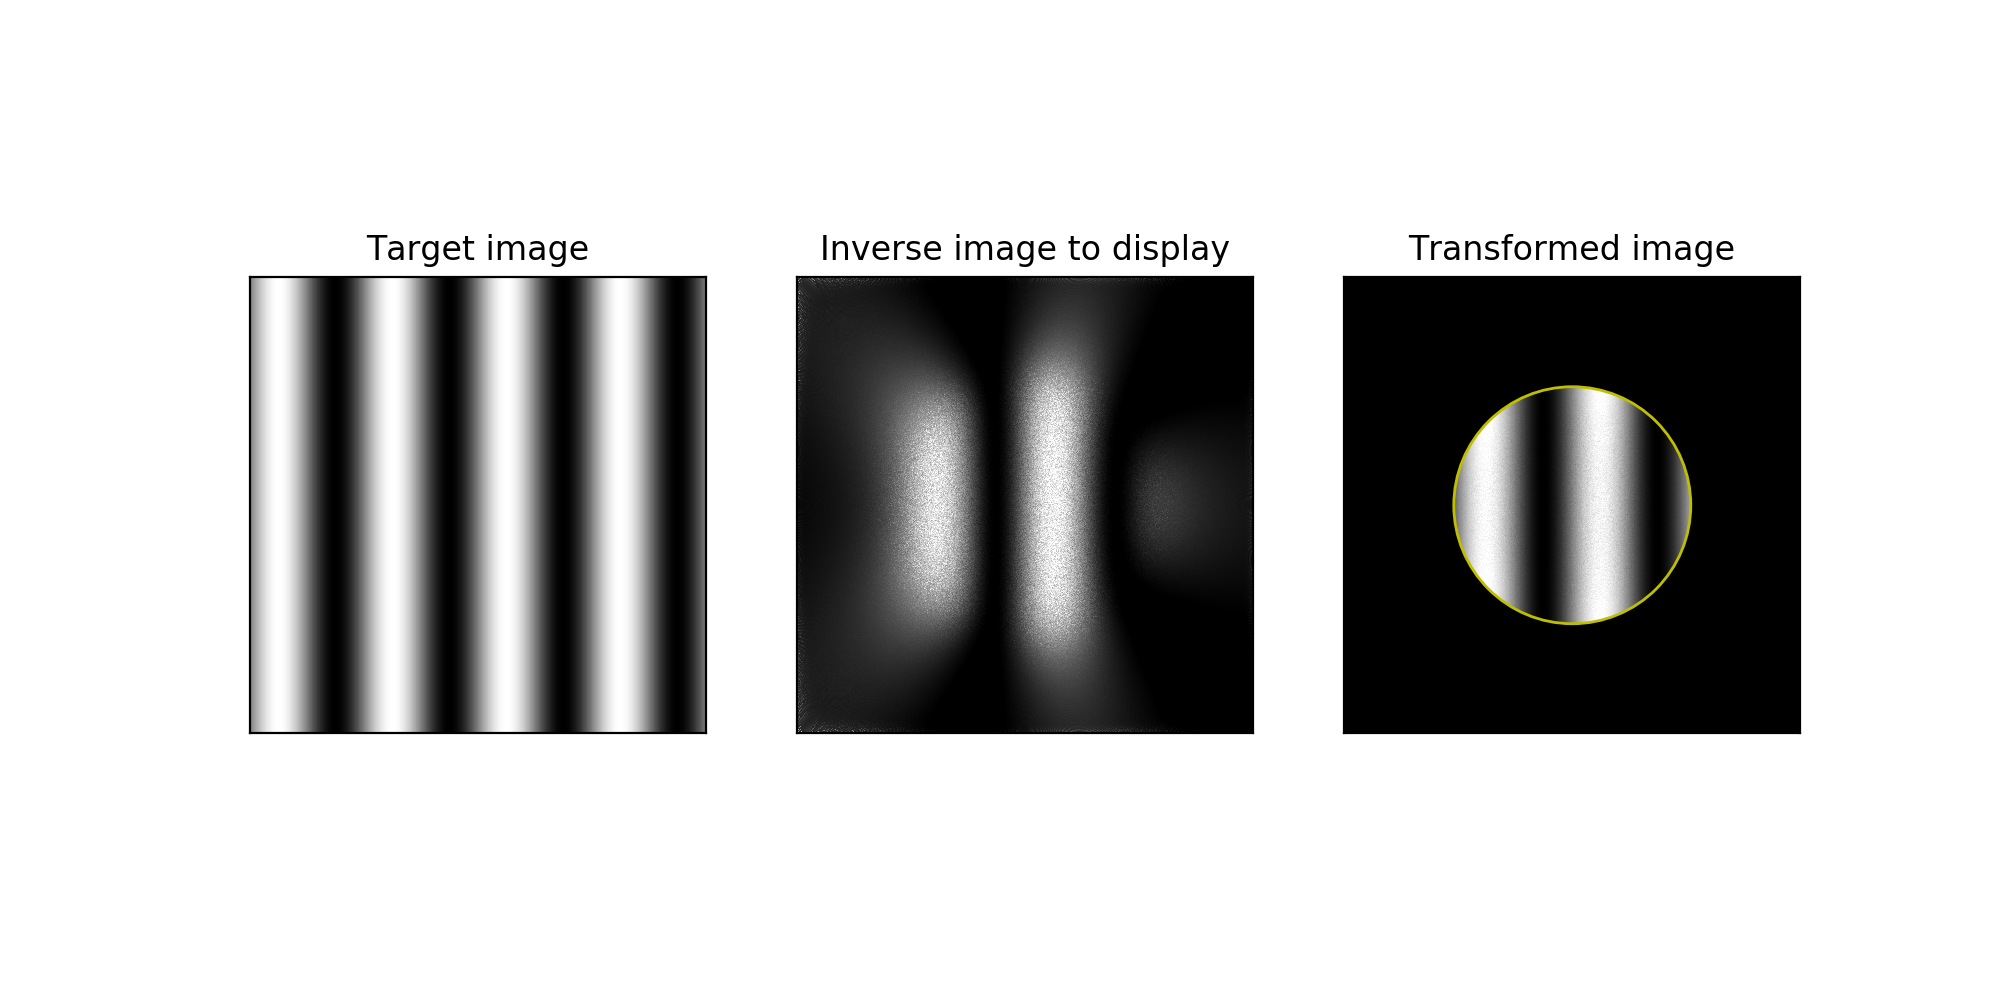

In [41]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(OMR_air,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Target image')
plt.subplot(132)
plt.imshow(inverse,vmin=np.min(OMR_air),vmax=np.max(OMR_air),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Inverse image to display')
plt.subplot(133)
plt.imshow(forward,vmin=np.min(OMR_air),vmax=np.max(OMR_air),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Transformed image")
# Plot scale bar
display_stochastic.add_scale()

# Compare naive and Snell-corrected OMR gratings

Although it is impossible to present a whole-field OMR stimulus across an air-water interface, designing an "Inverse image" by accounting for Snell's law is still helpful, because it can generate a more uniform OMR stimulus within the Snell window.

<IPython.core.display.Javascript object>


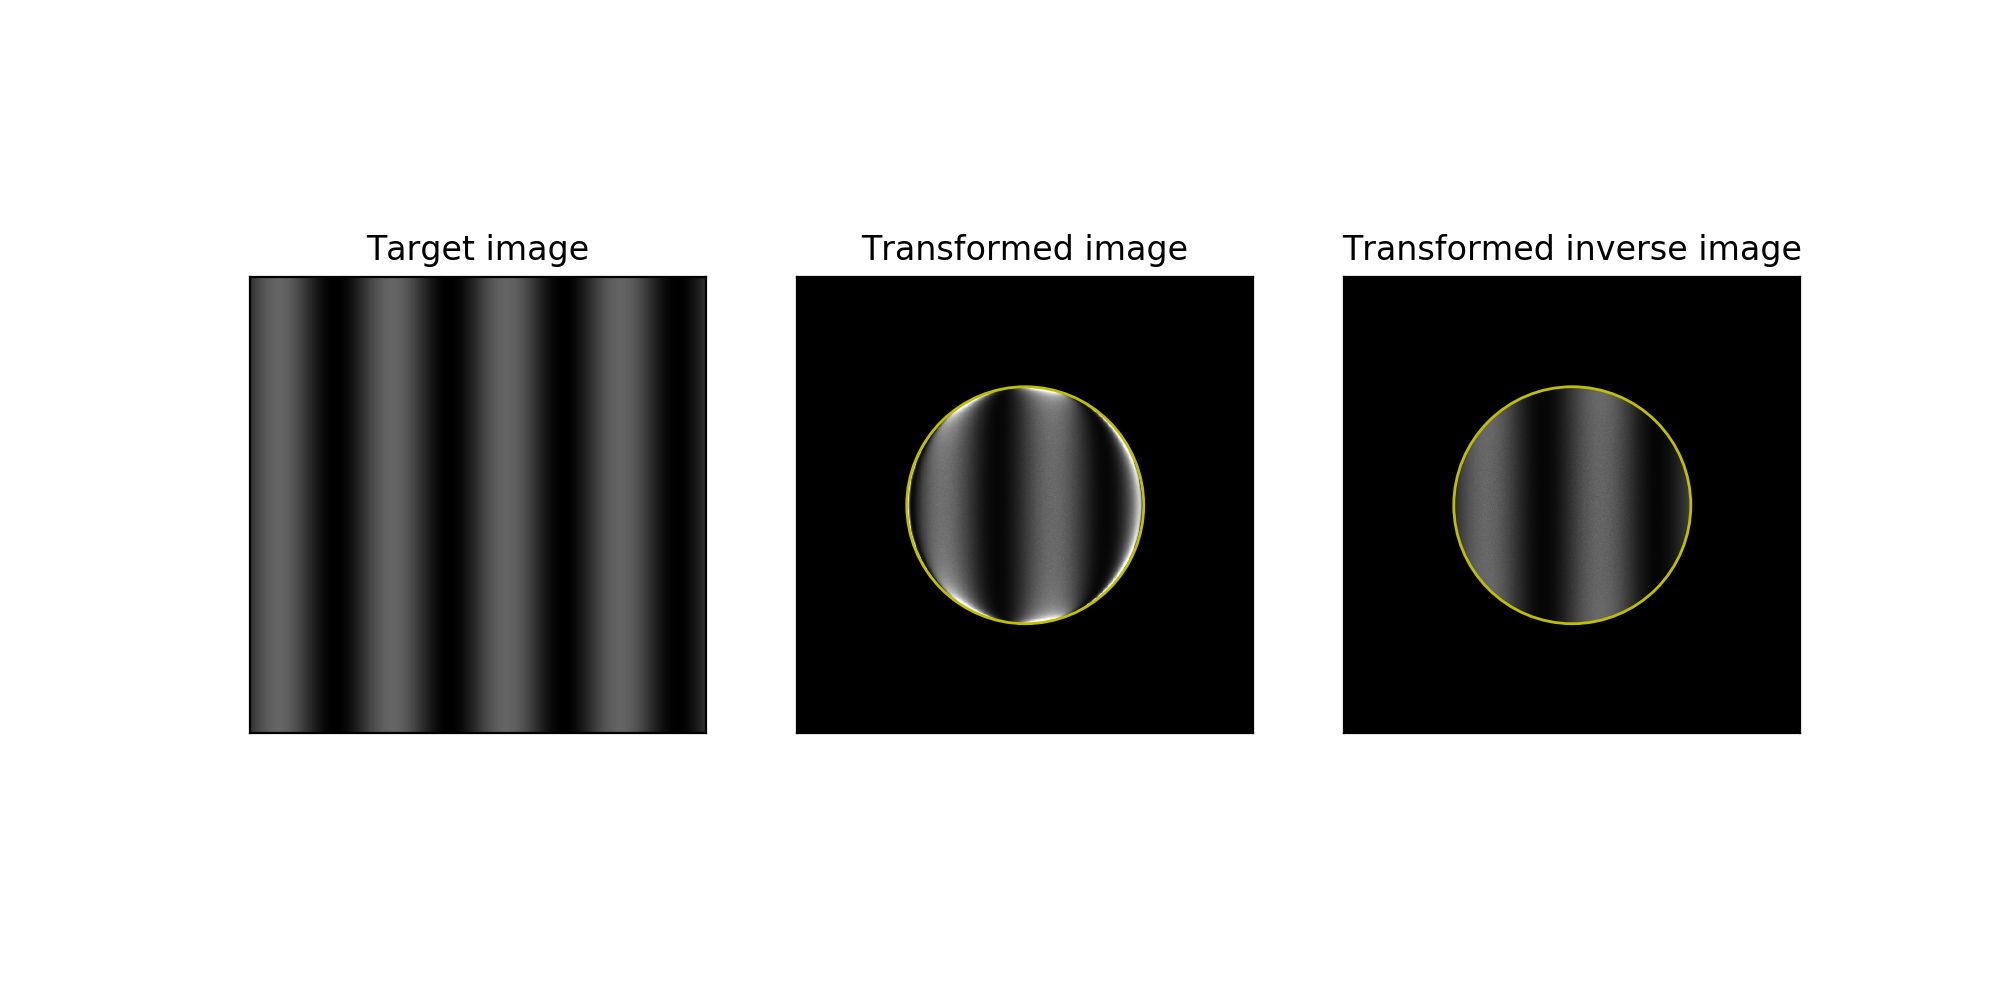

In [42]:
# Set image saturation
VMAX = 650

plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(OMR_air,vmax=VMAX,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Target image")
plt.subplot(132)
plt.imshow(OMR_snell_stochastic,vmax=VMAX,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Transformed image")
# Plot scale bar
display_stochastic.add_scale()
plt.subplot(133)
plt.imshow(forward,vmax=VMAX,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Transformed inverse image")
display_stochastic.add_scale()